In [1]:
import numpy as np 
import uproot 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys

#Drop Mass because all 0

In [14]:
import pandas as pd
#Columns names that are always the same for this data
columns = ['Event Number','Topocluster number','time', 'clusterSize', 'eta0', 'phi0', 'rawE', 'rawEta', 'rawPhi',
           'rawM','altE', 'altEta', 'altPhi', 'altM', 'calE', 'calEta', 'calPhi', 'calM', 'N_BAD_CELLS', 'SIGNIFCANCE',
           'ENG_FRAC_MAX', 'FIRST_ENG_DENS', 'ISOLATION', 'LATERAL', 'LONGITUDINAL', 'SECOND_LAMBDA', 'SECOND_R',
           'CENTER_LAMBDA', 'AVG_LAR_Q', 'CENTER_MAG', 'AVG_TITLE_Q', 'BADLARQ_FRAC', 'CELL_SIGNIFICANCE',
           'CELL_SIG_SAMPLING', 'BadChannelList', 'ENG_BAD_CELLS', 'ENG_POS', 'EM_PROBABILITY']
#File is delimited by *, last line is ****..., python engine must be used to use skipfooter
data = pd.read_csv('../raw_data/ryan_v2_fixed.dat',delimiter = '*', header = None, names = columns, skipfooter=1, index_col=False, engine='python')


In [3]:
data

,rawE,rawEta,rawPhi,rawM
0,119253.9100,2.978673,0.931546,0
1,8318.3974,-0.572487,-2.307804,0
2,8141.1879,-0.703969,-2.277976,0
3,5902.8935,-0.550116,-2.229533,0
4,91260.1480,-4.150464,-1.876422,0
...,...,...,...,...
212329,-243.0000,0.263601,-2.602825,0
212330,-315.0000,-0.783005,0.141291,0
212331,-558.7150,-1.494254,-3.048022,0
212332,-277.1340,0.115666,1.772398,0


In [4]:
columns= columns[6:10]

# Plotting the initial Data

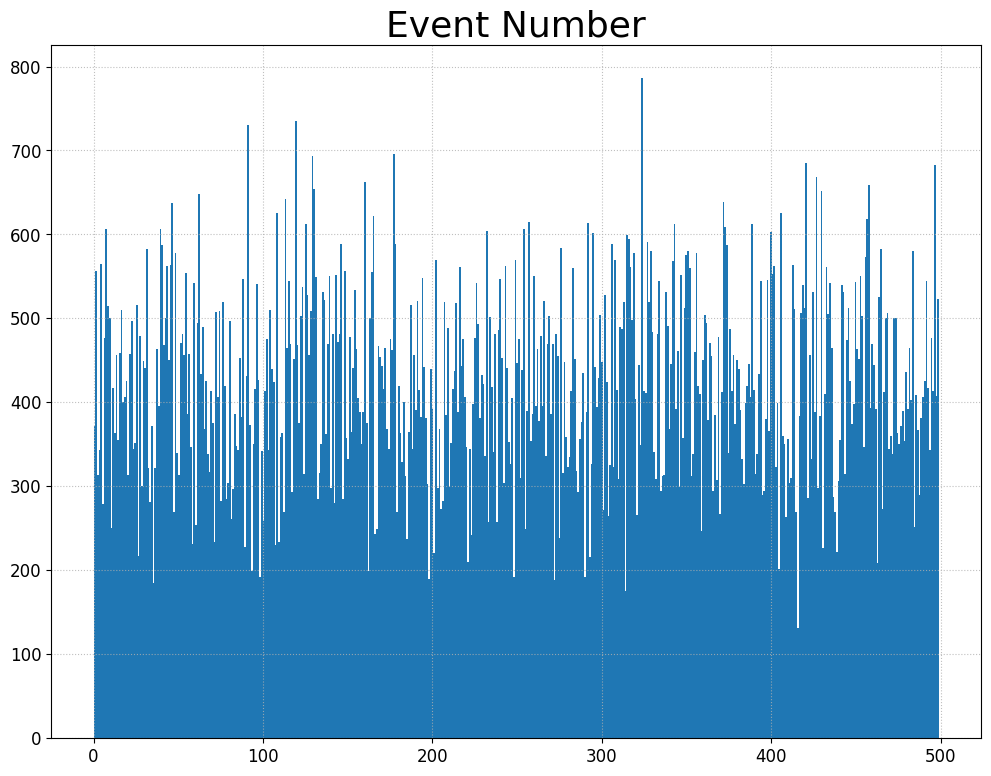

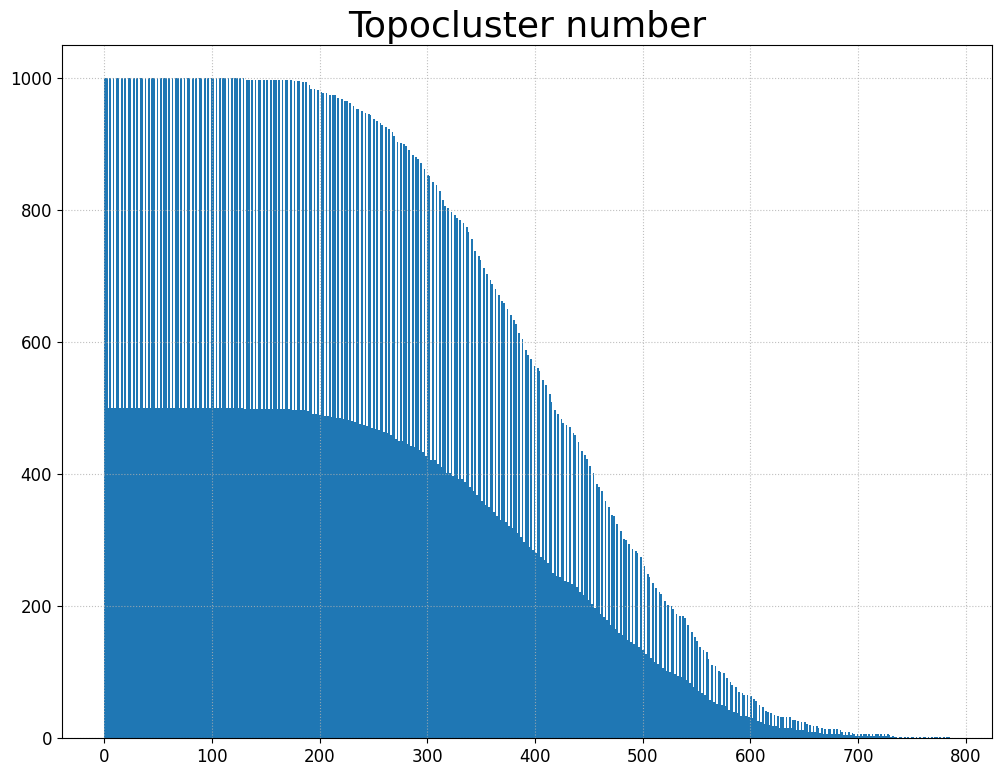

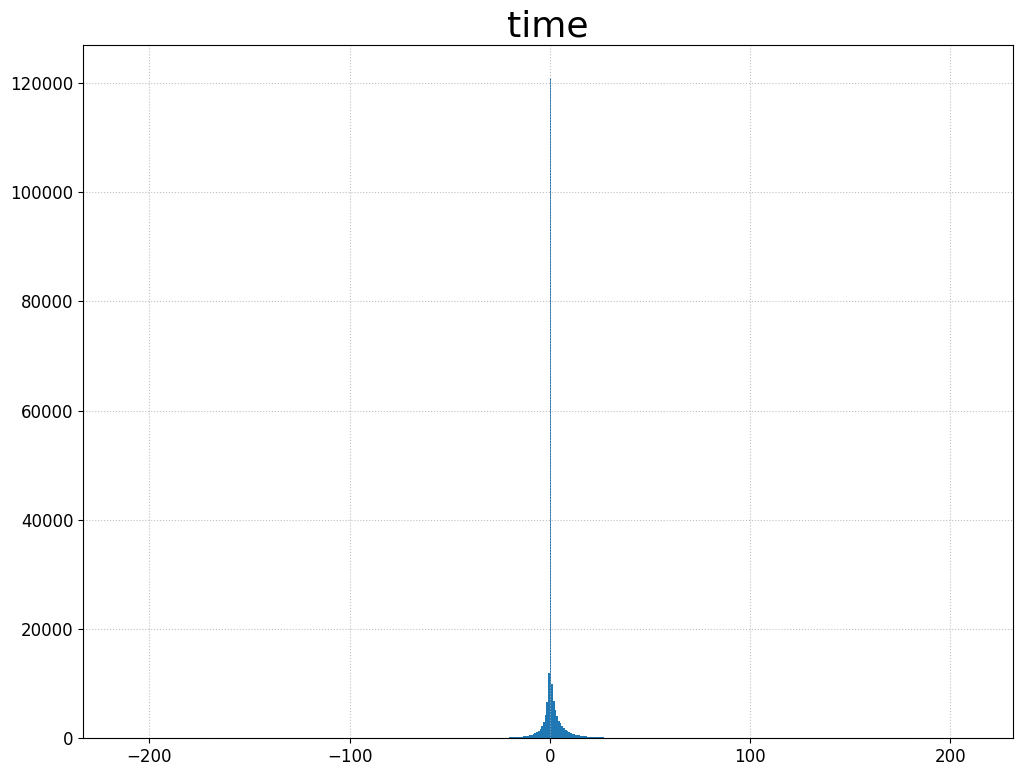

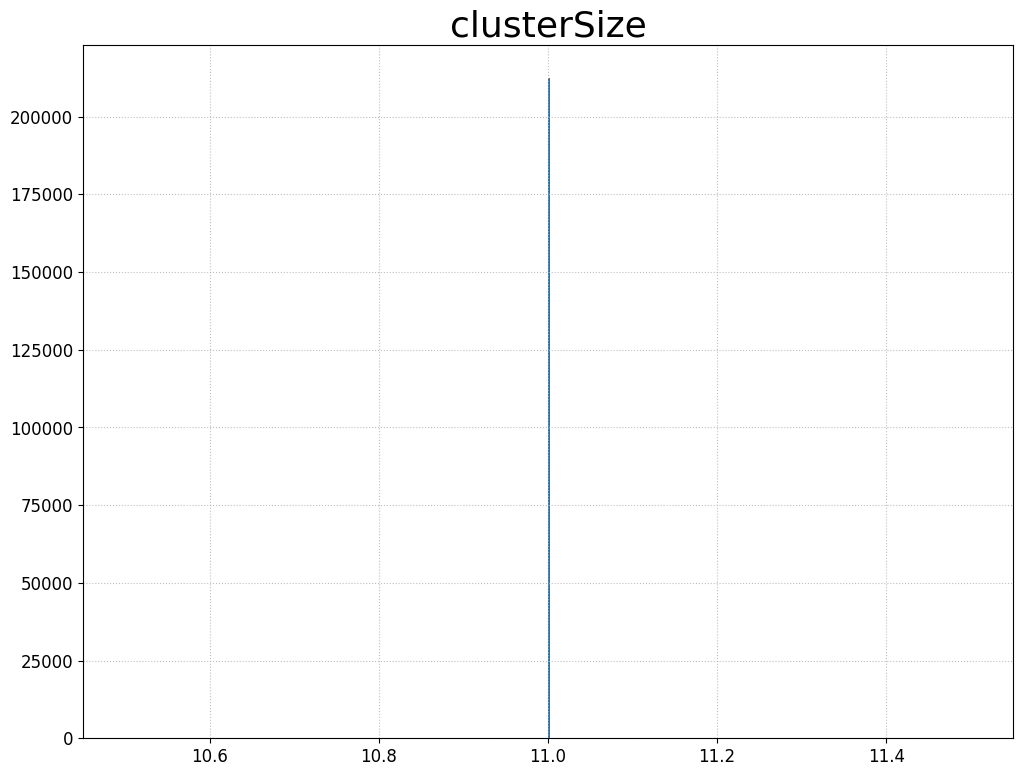

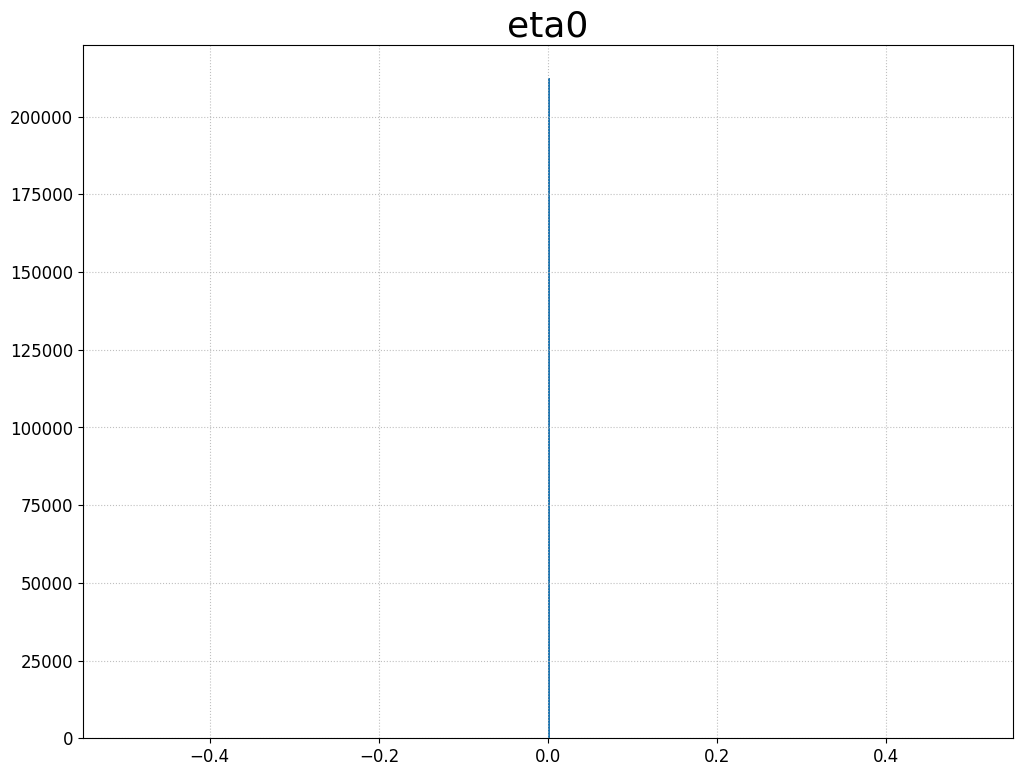

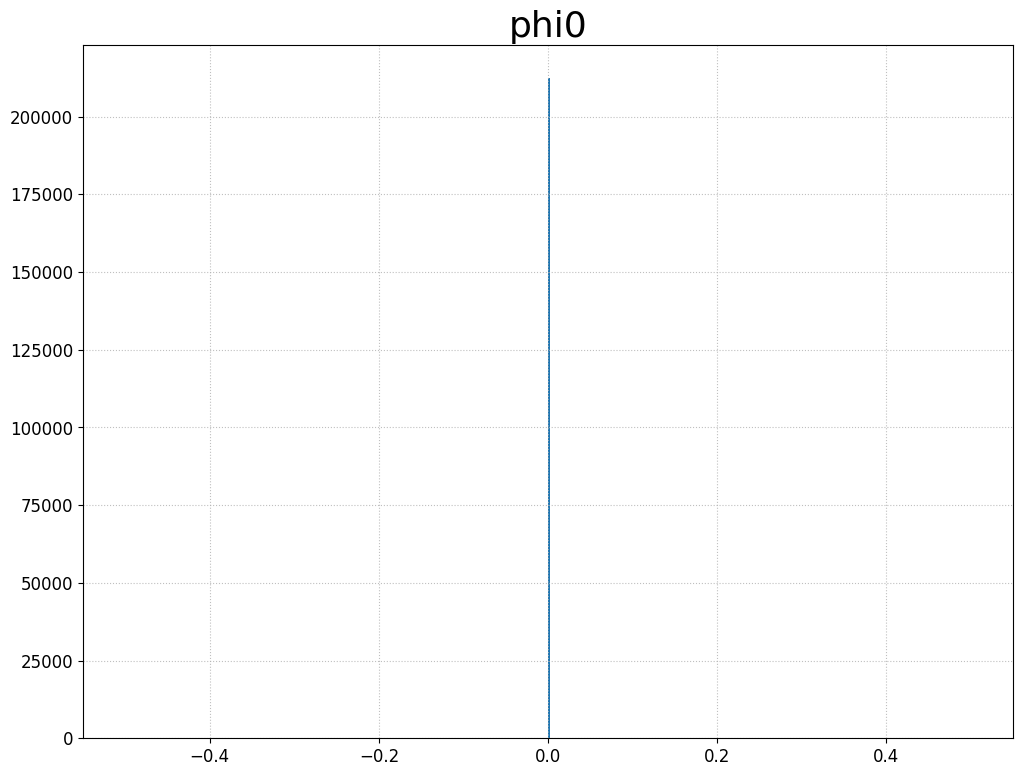

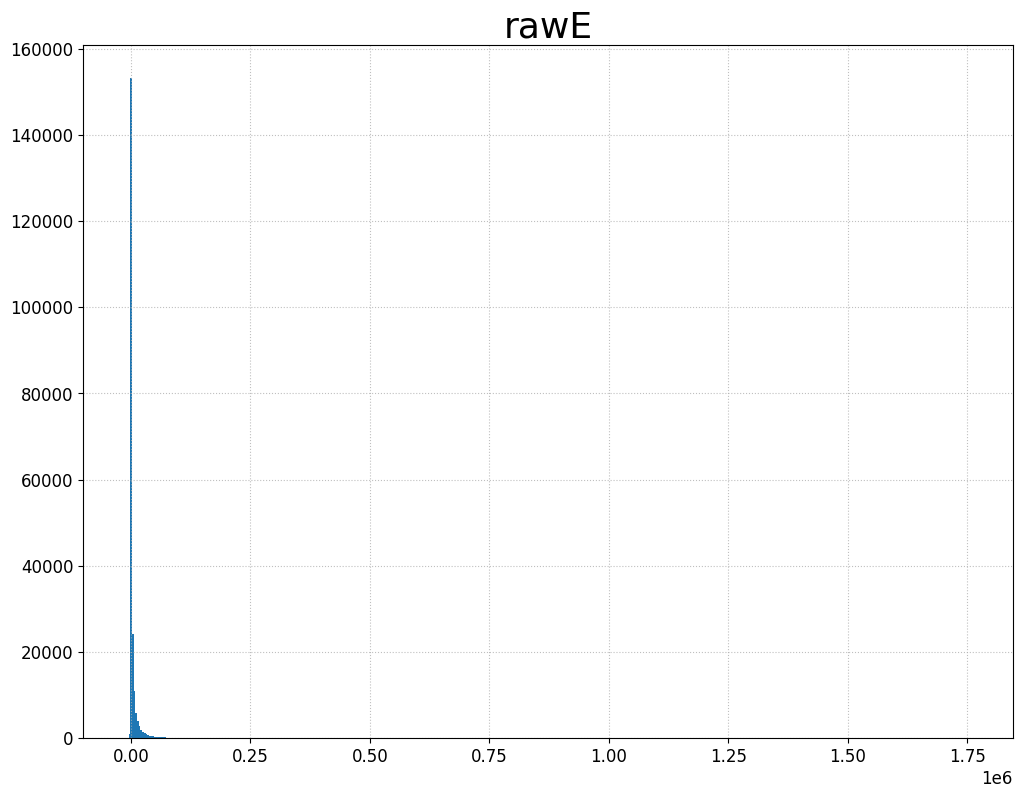

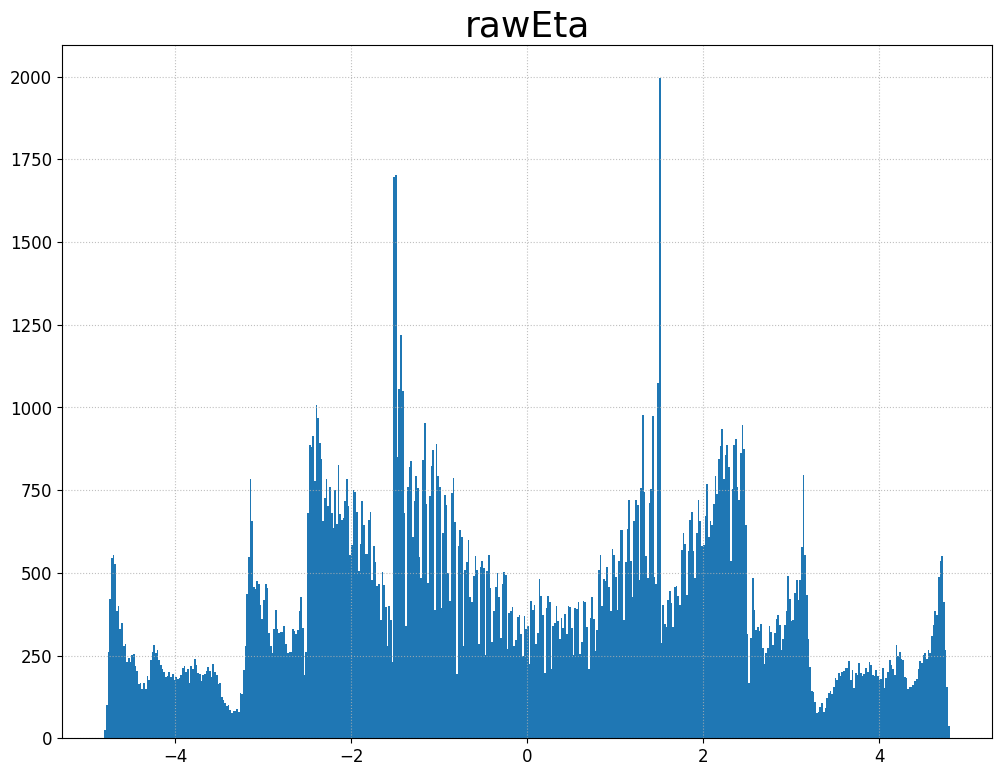

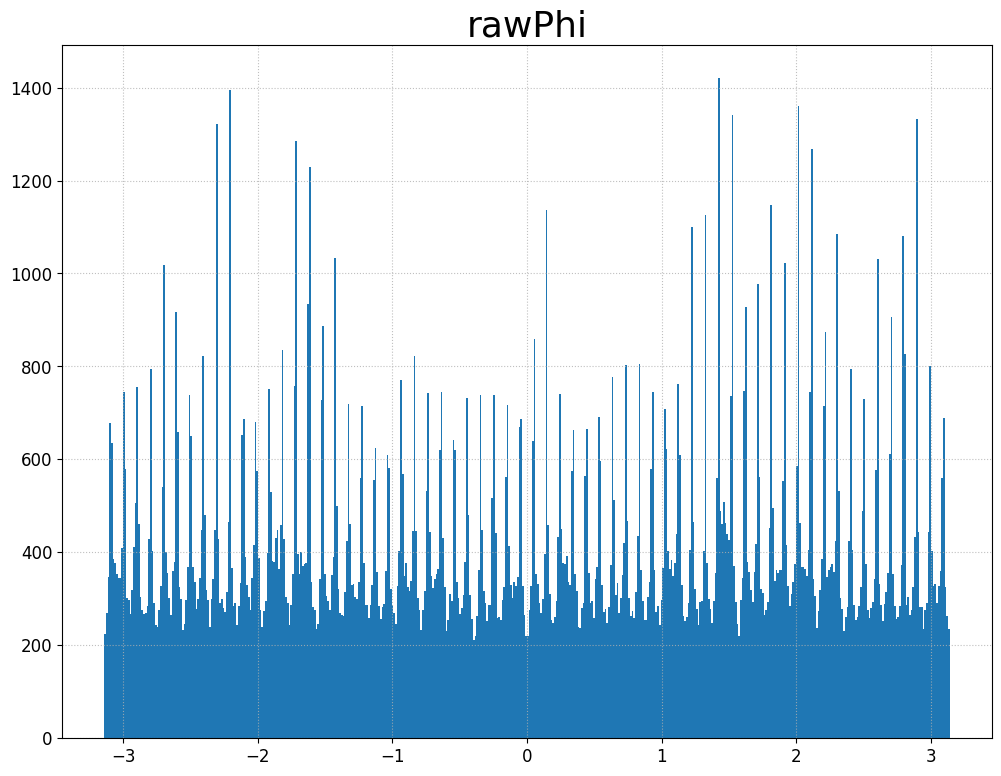

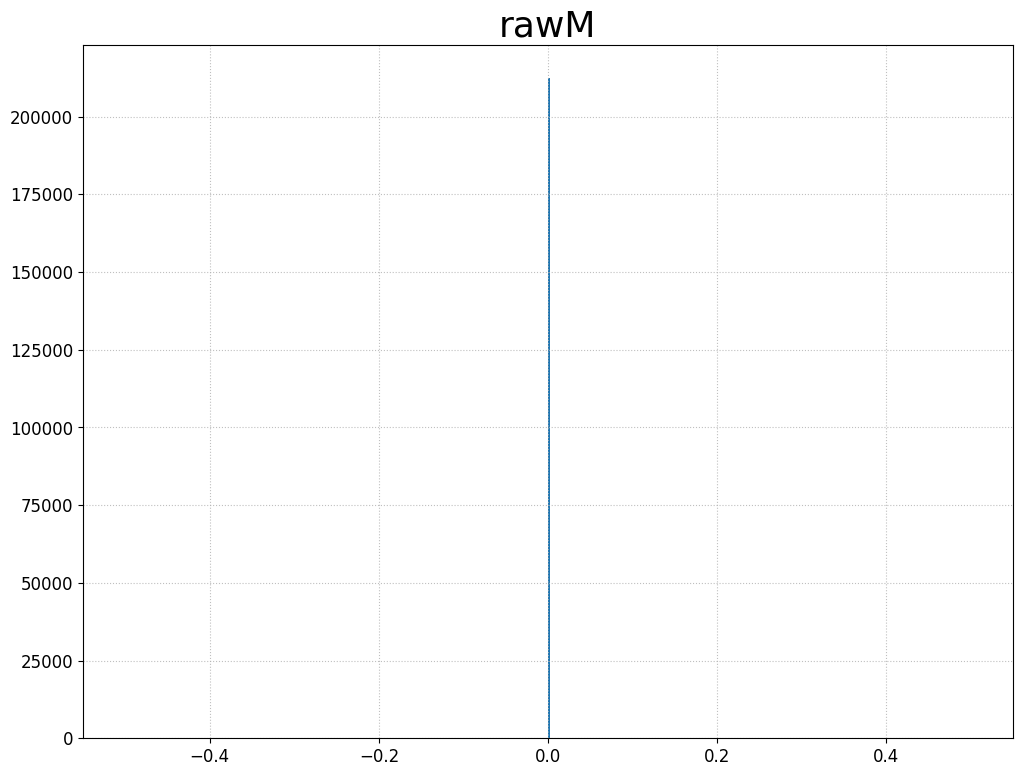

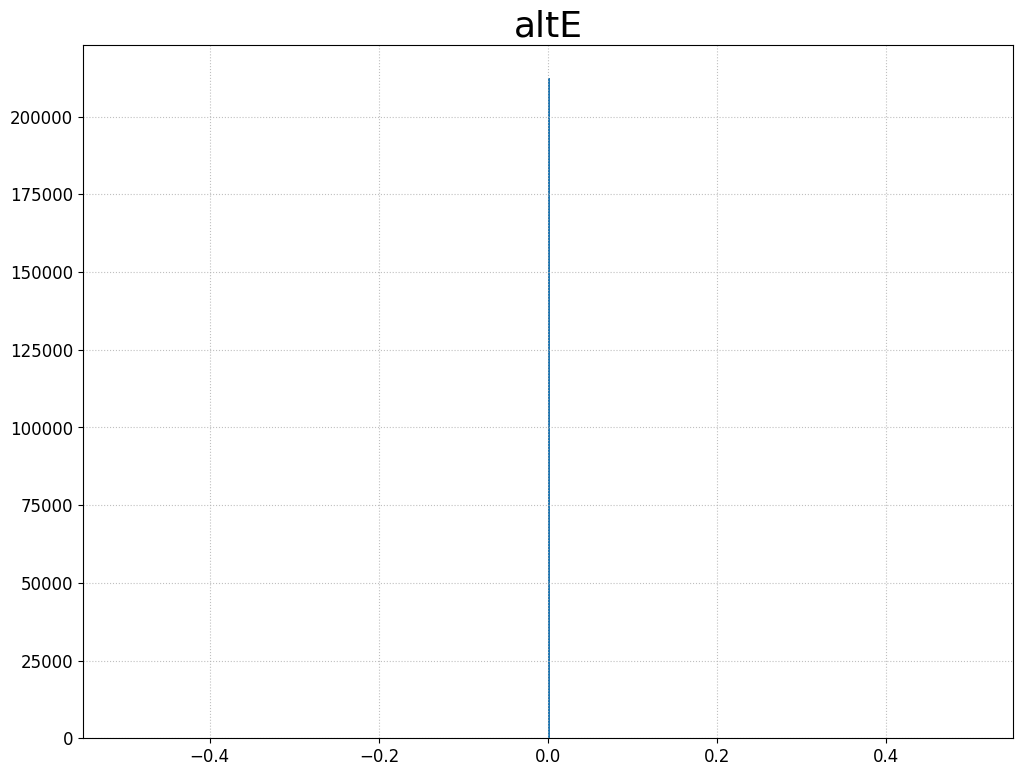

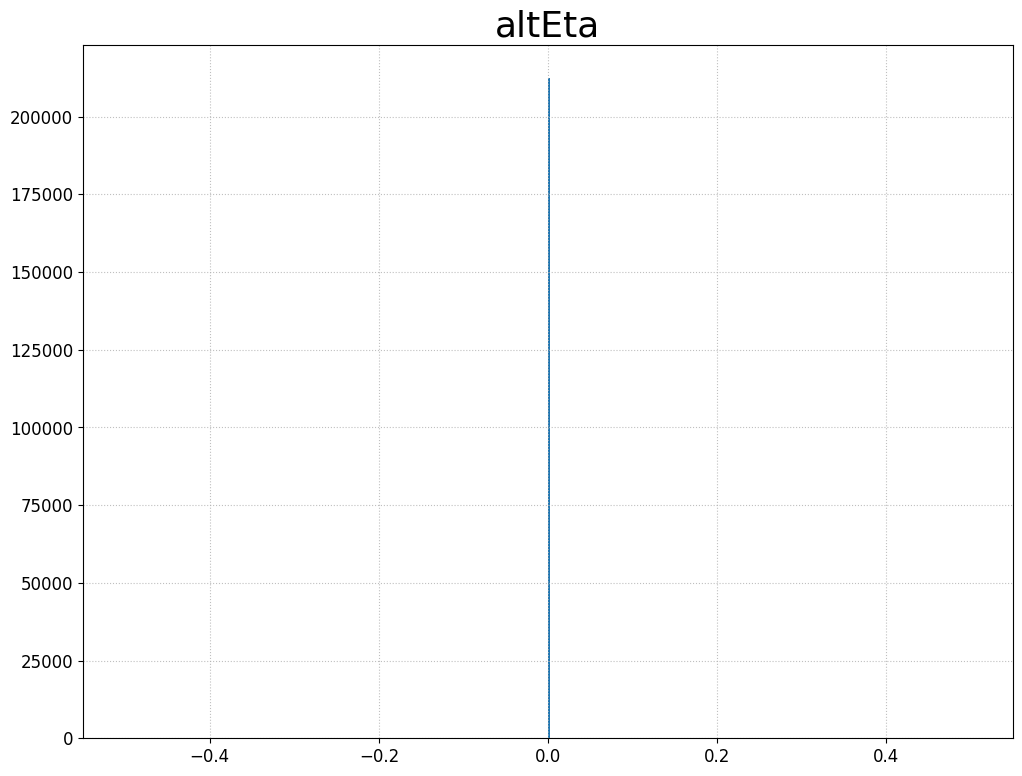

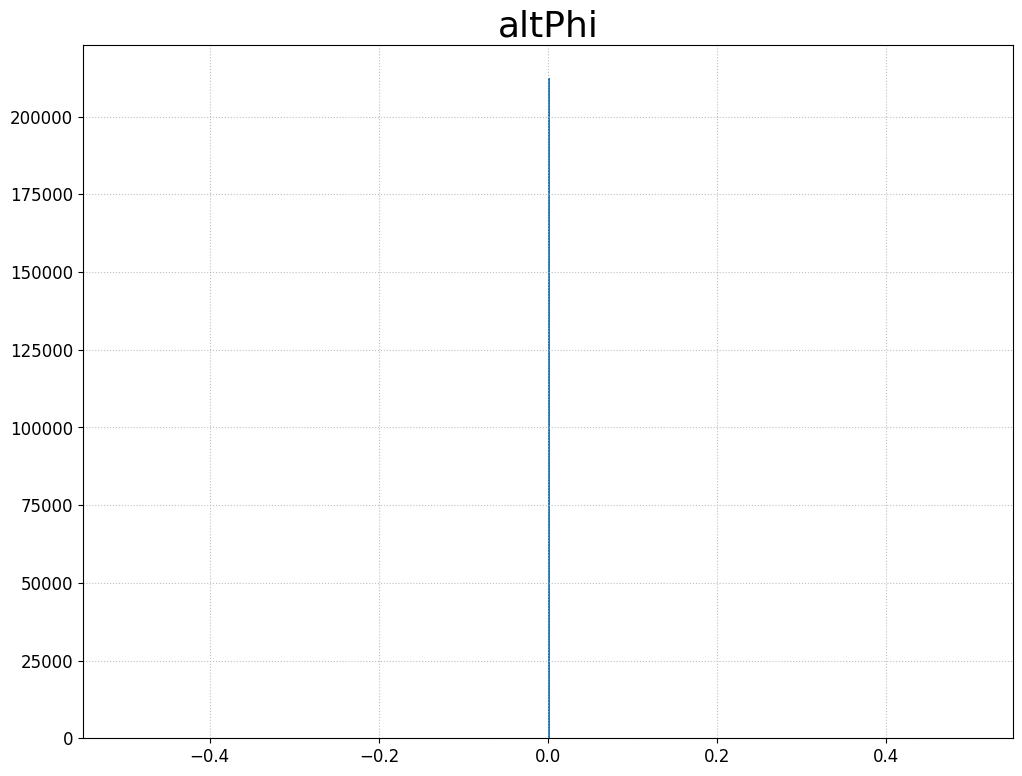

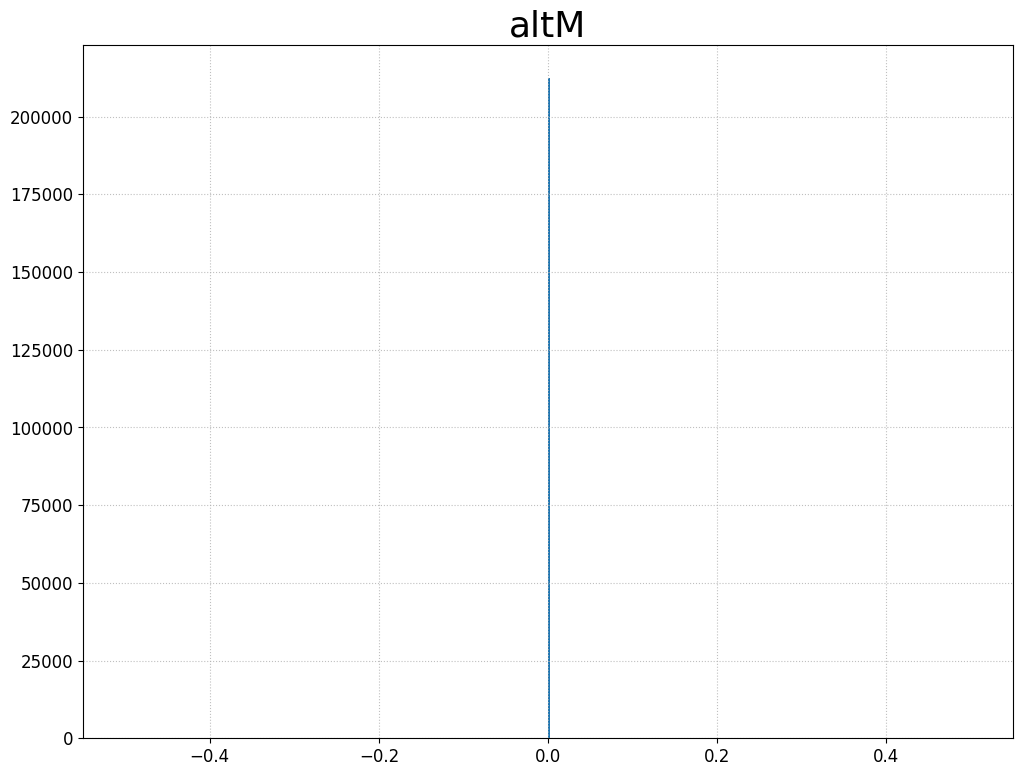

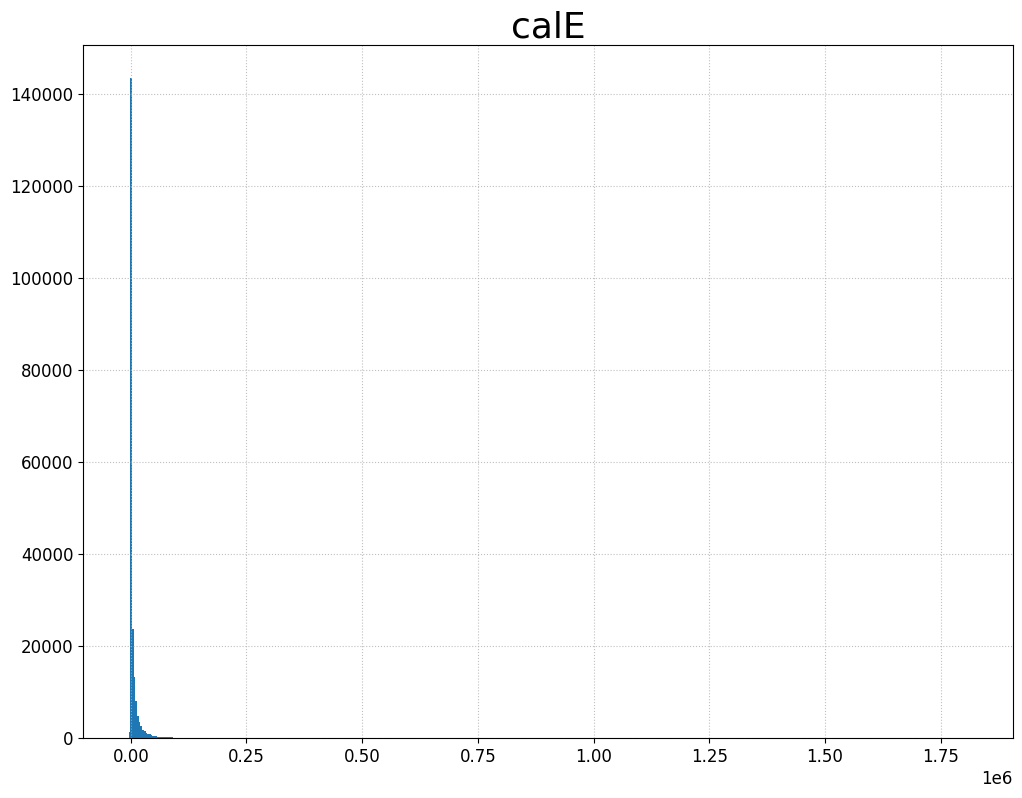

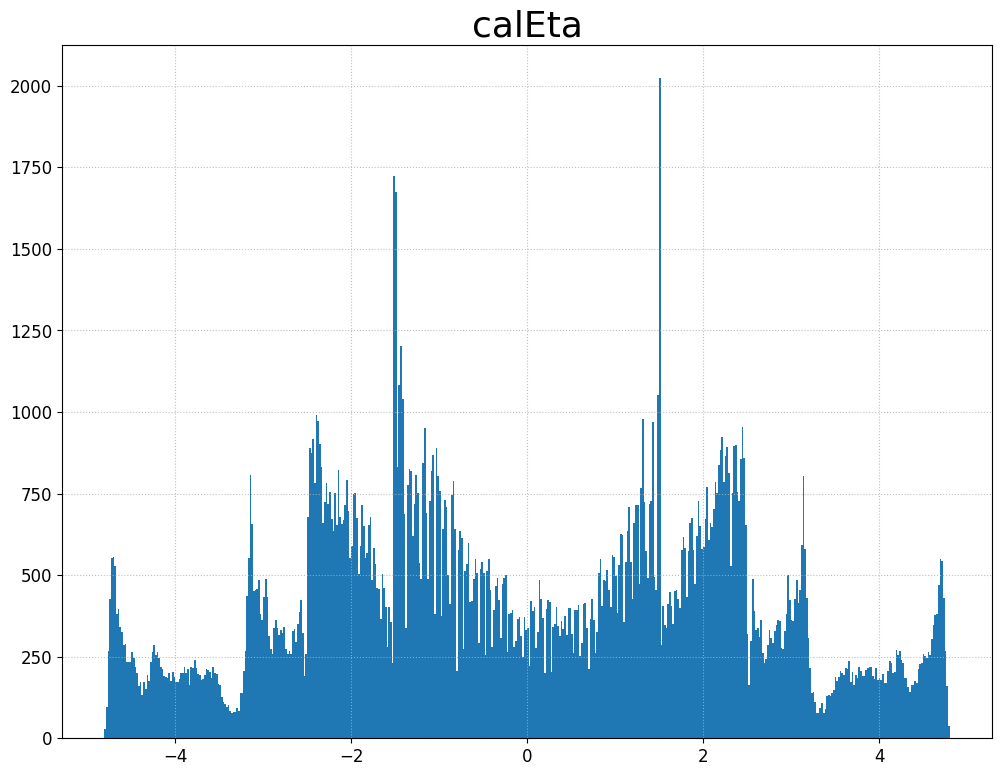

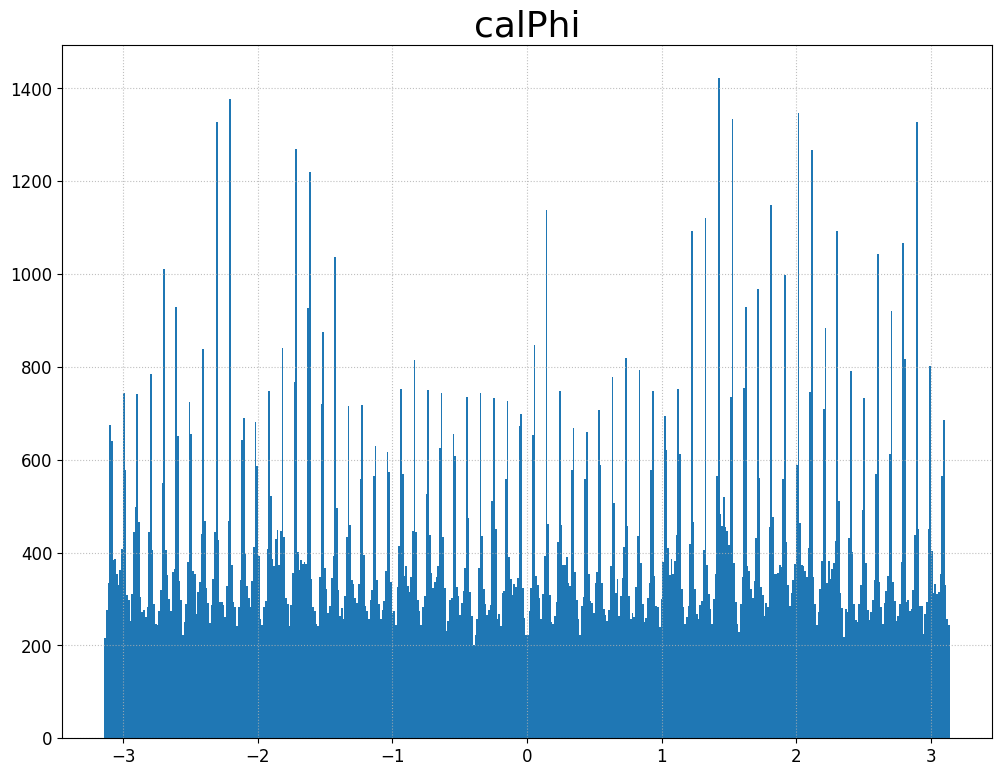

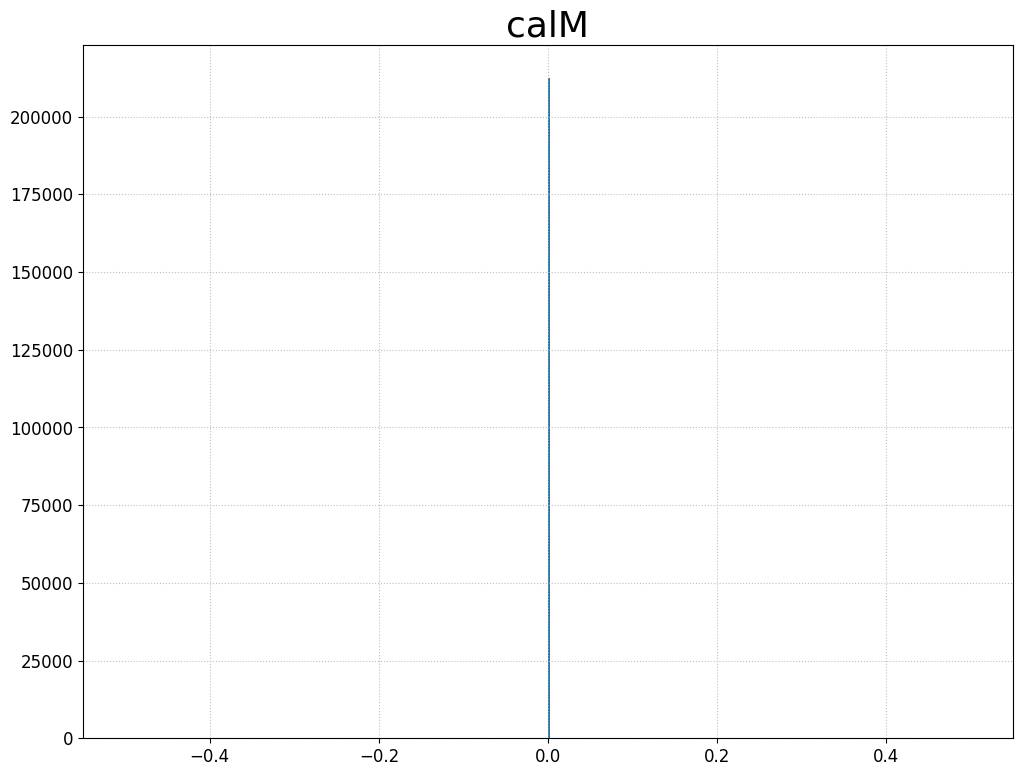

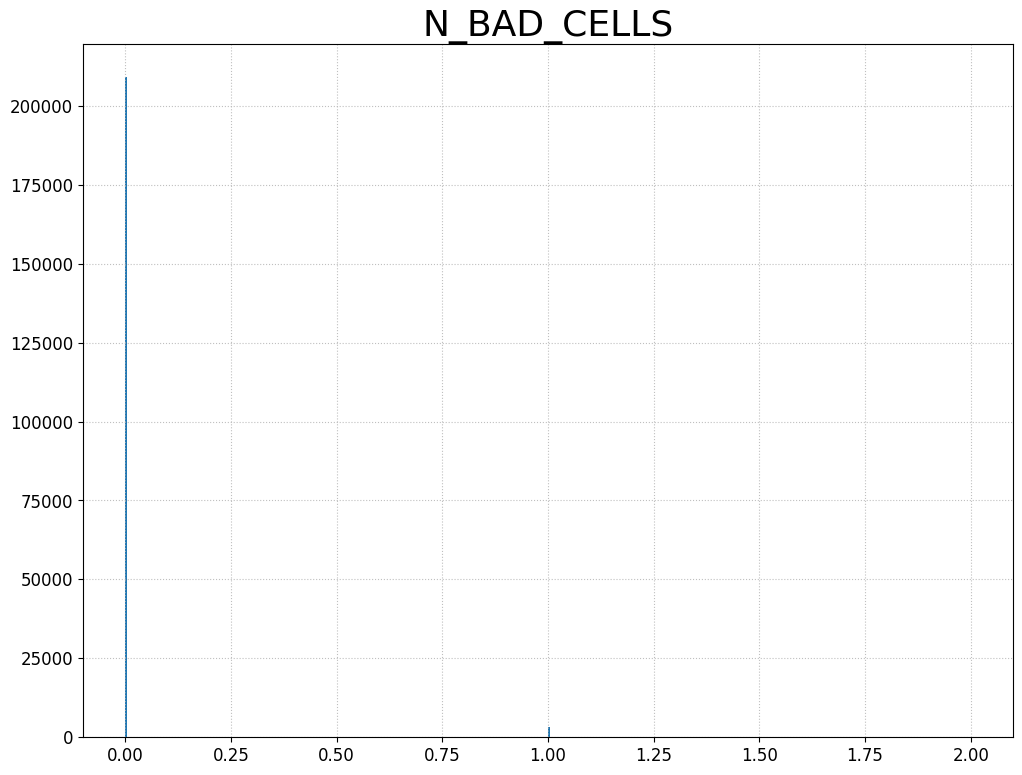

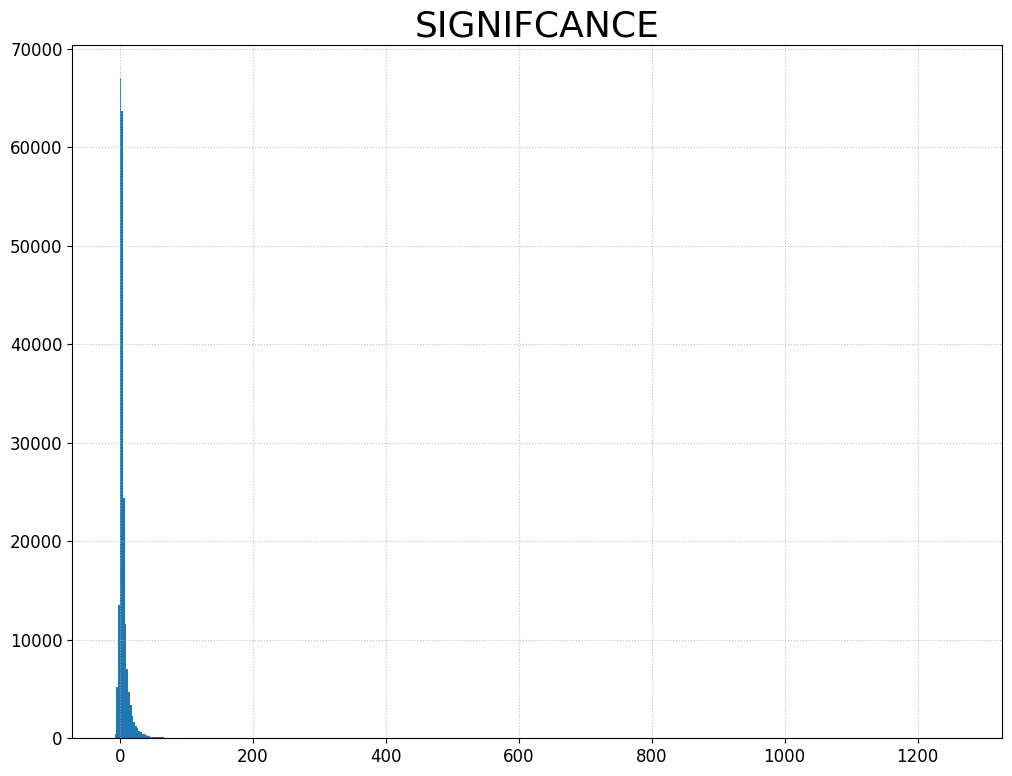

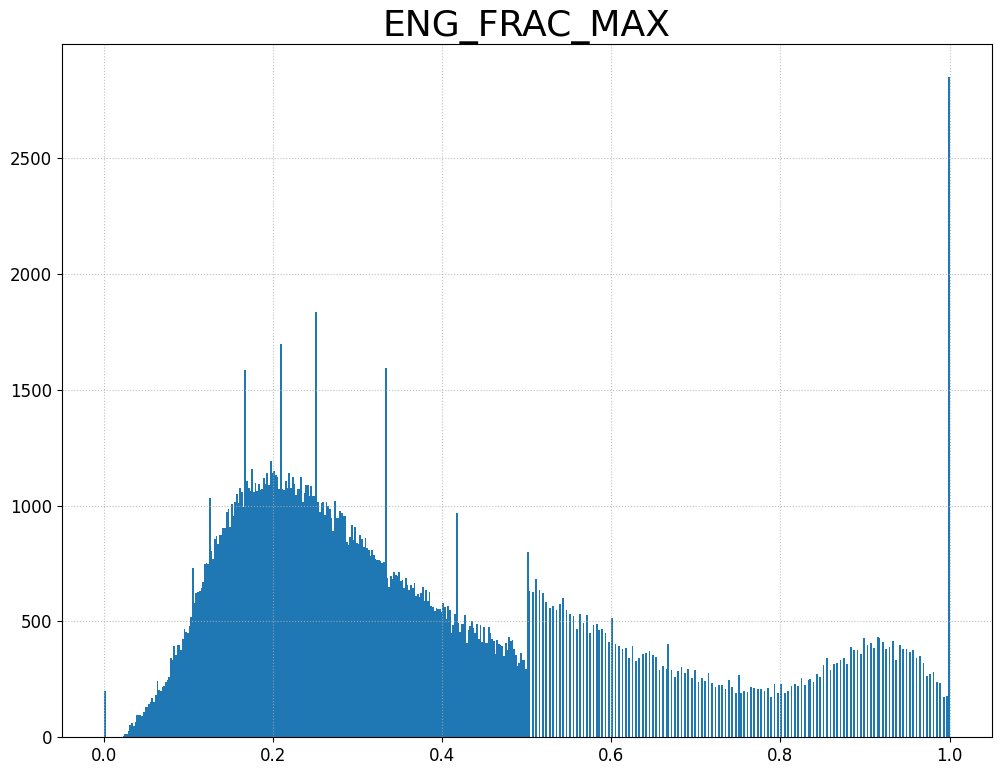

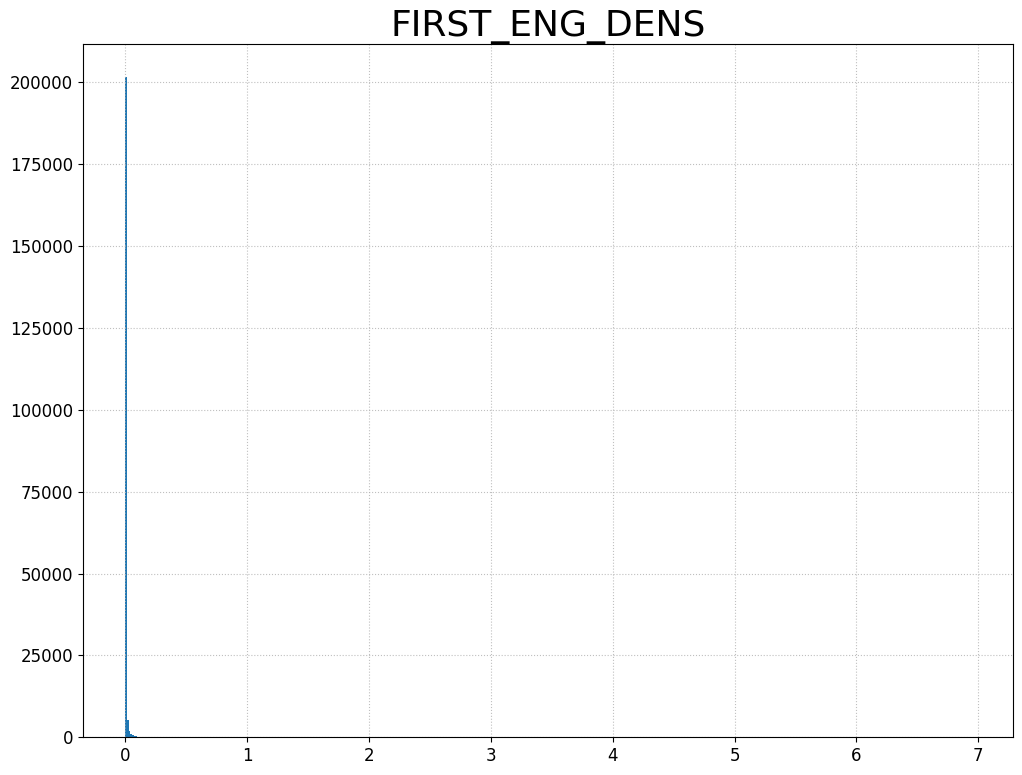

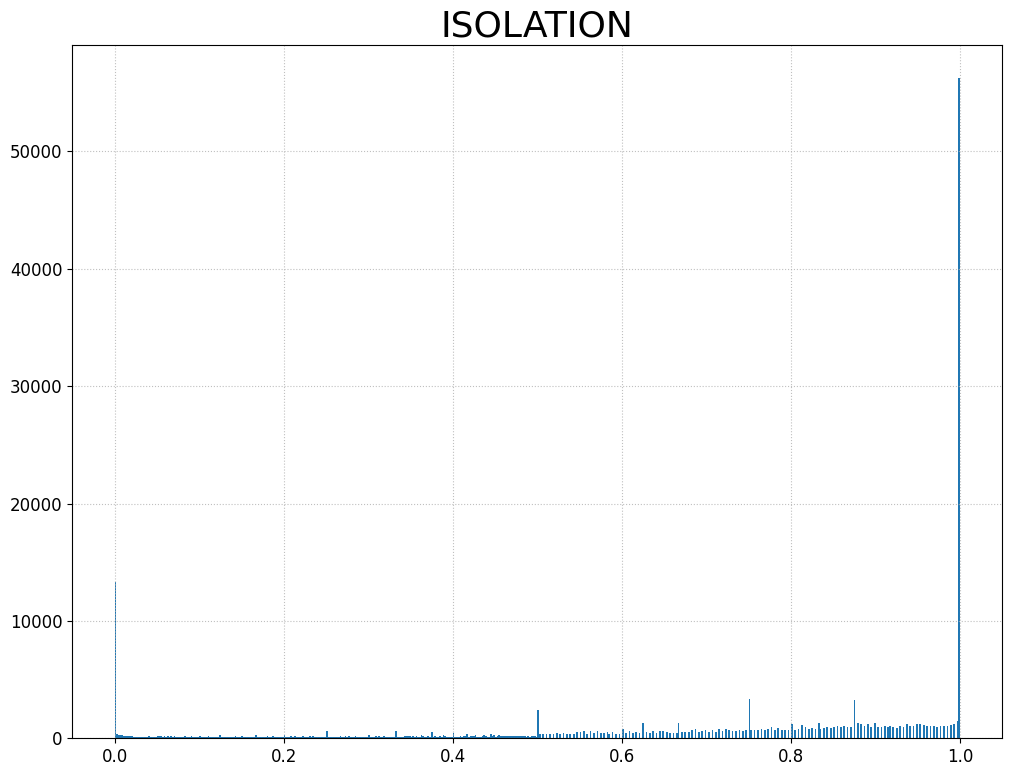

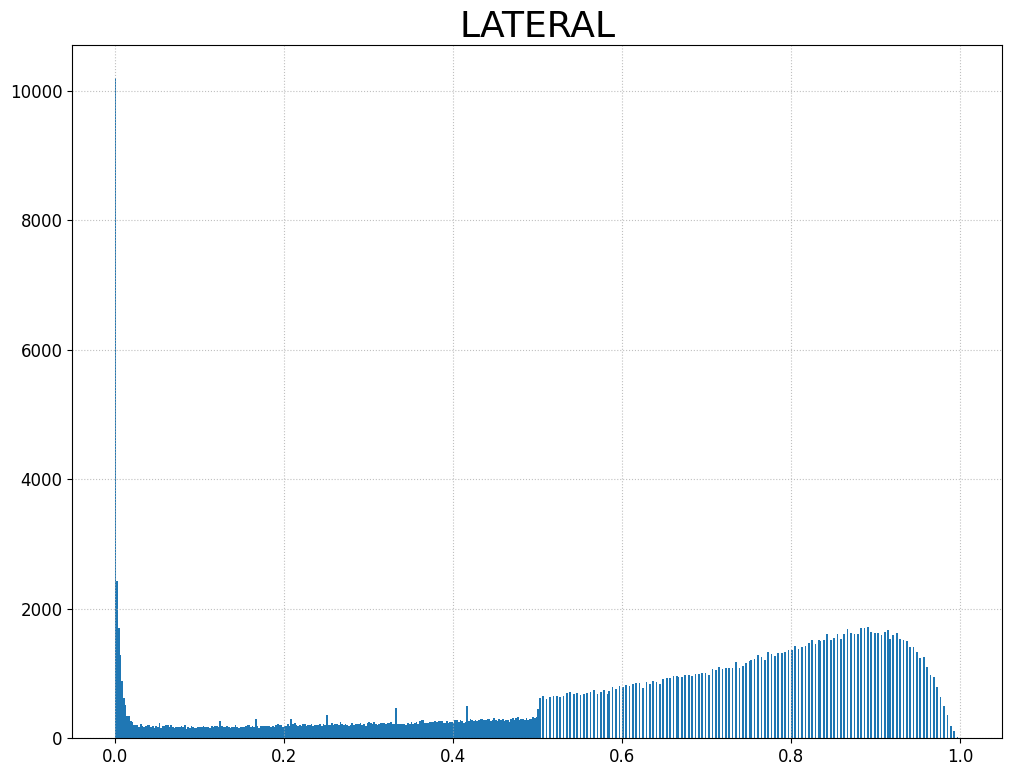

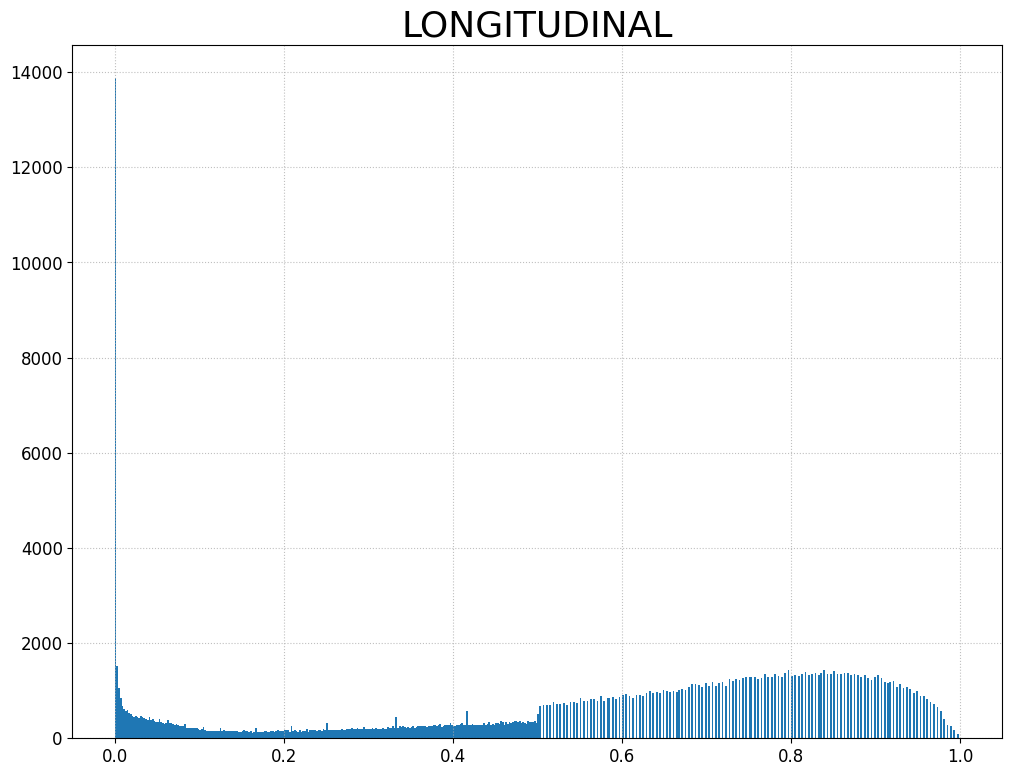

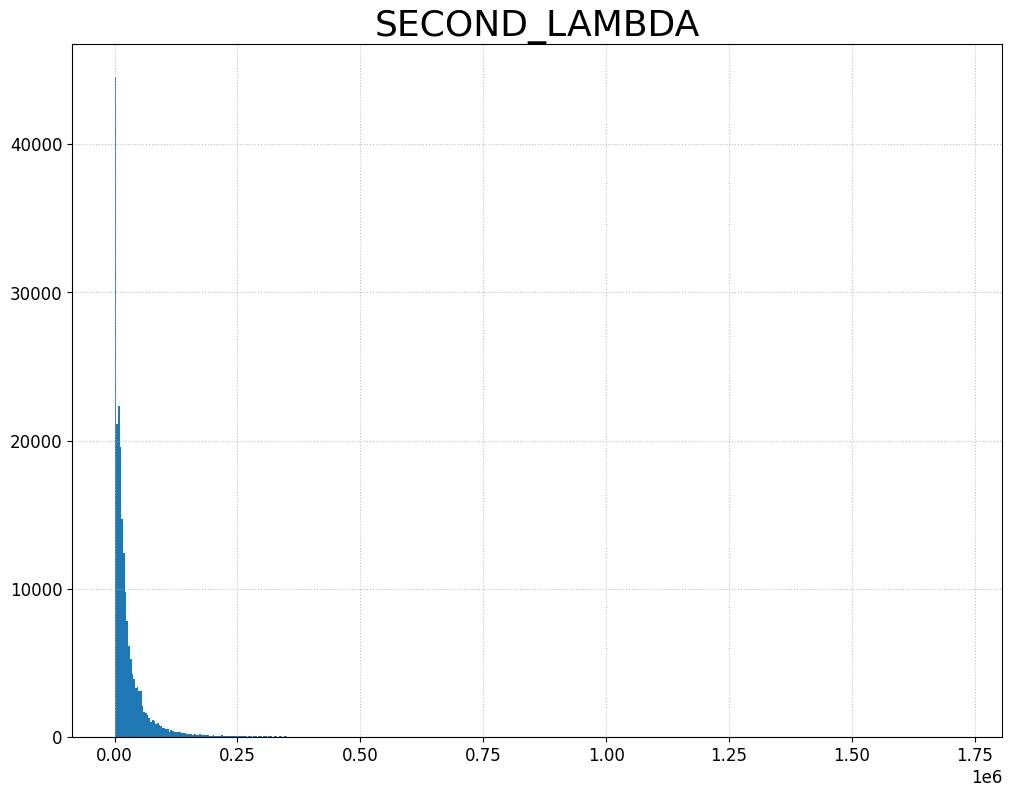

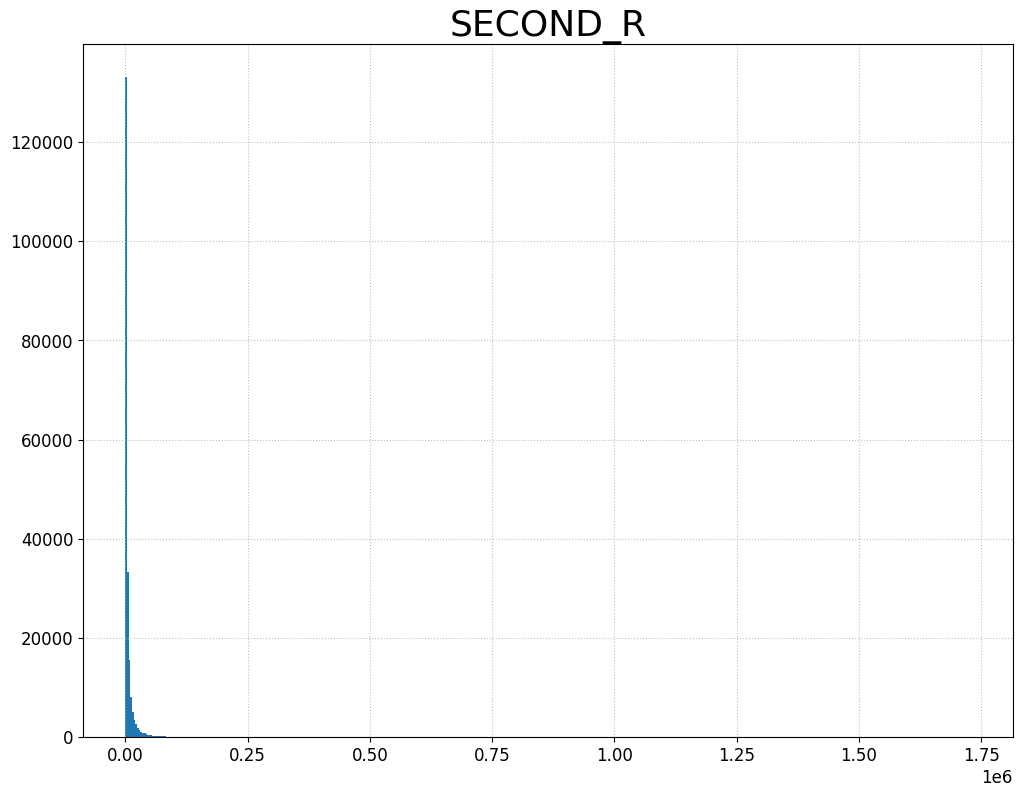

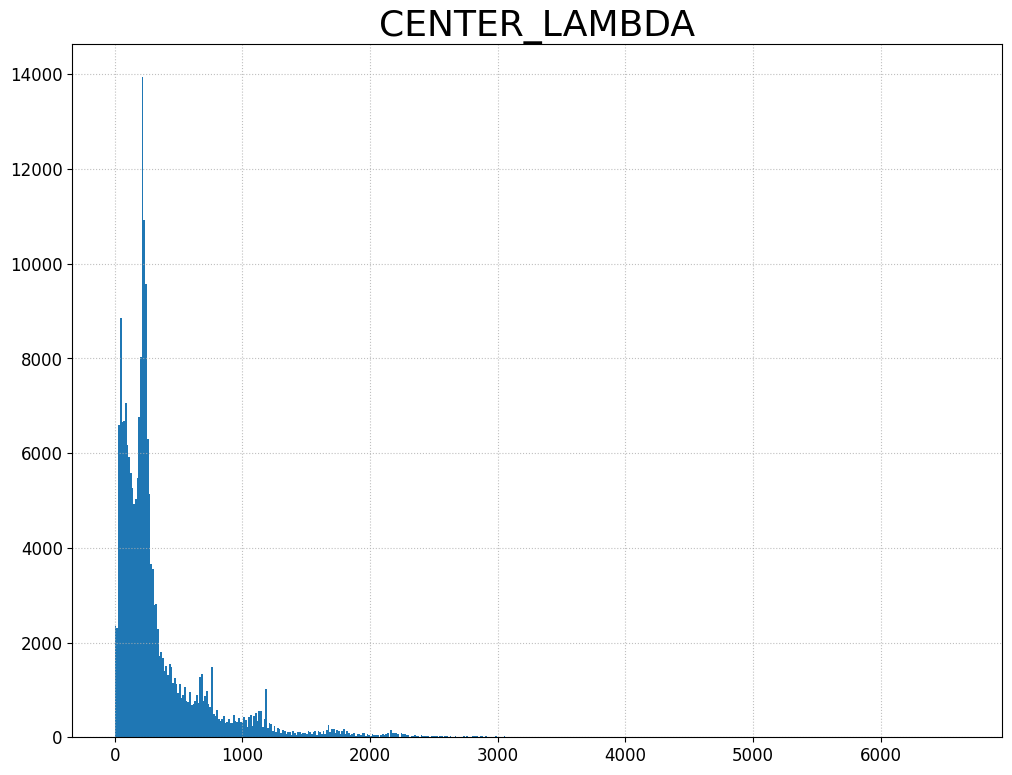

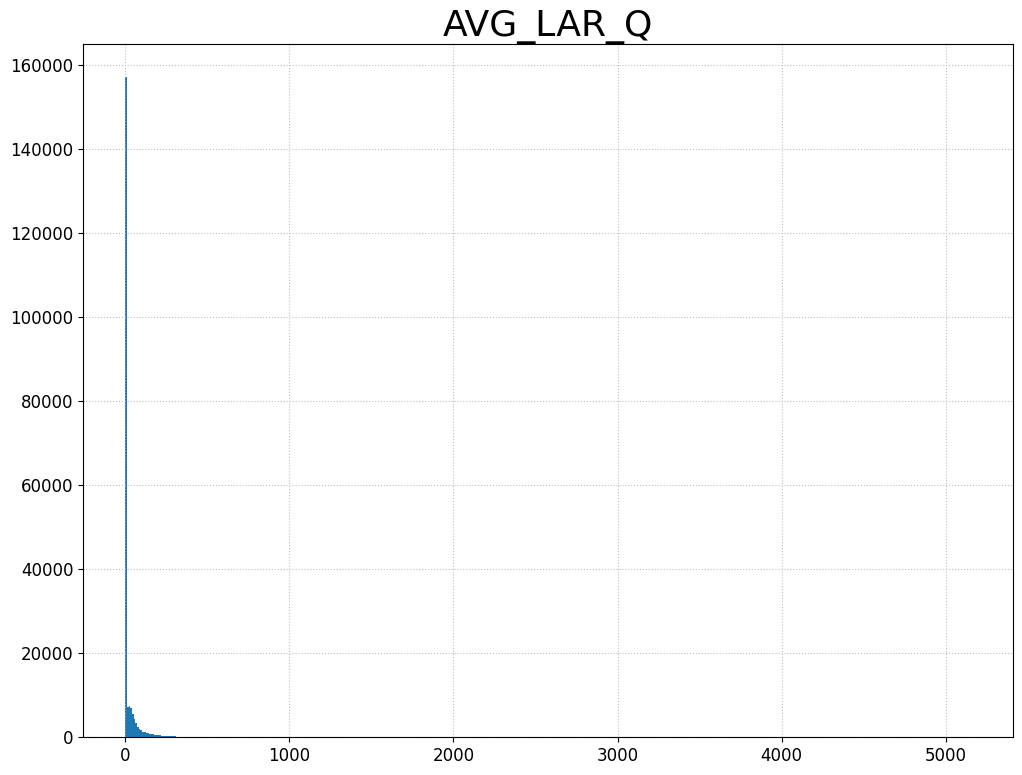

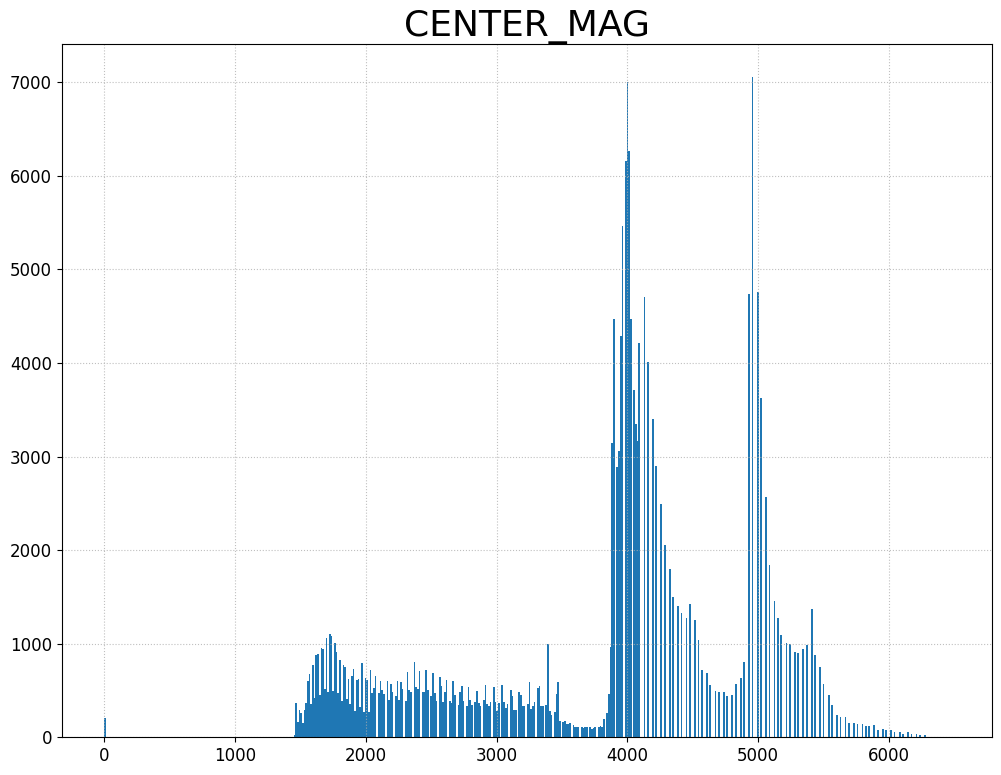

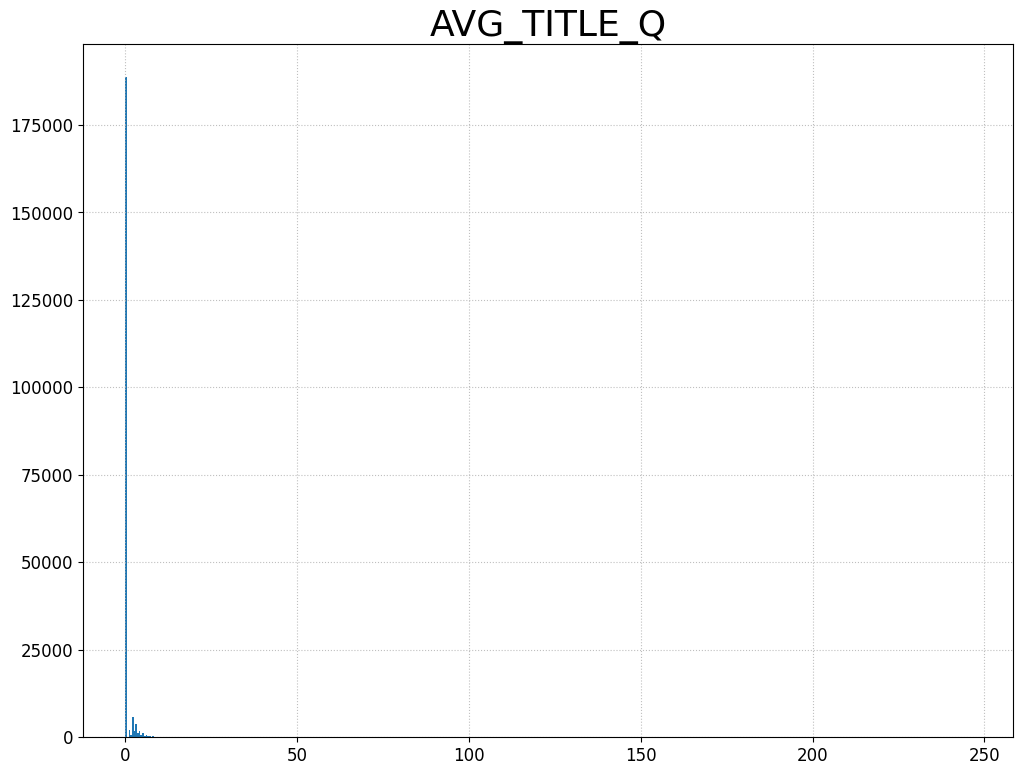

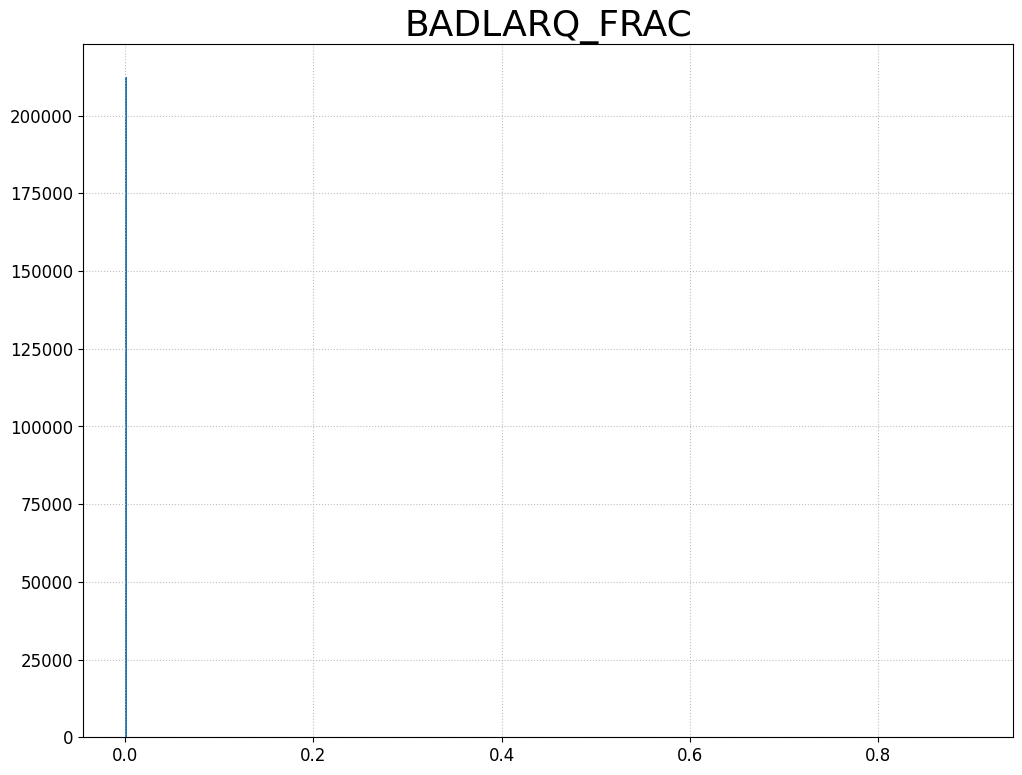

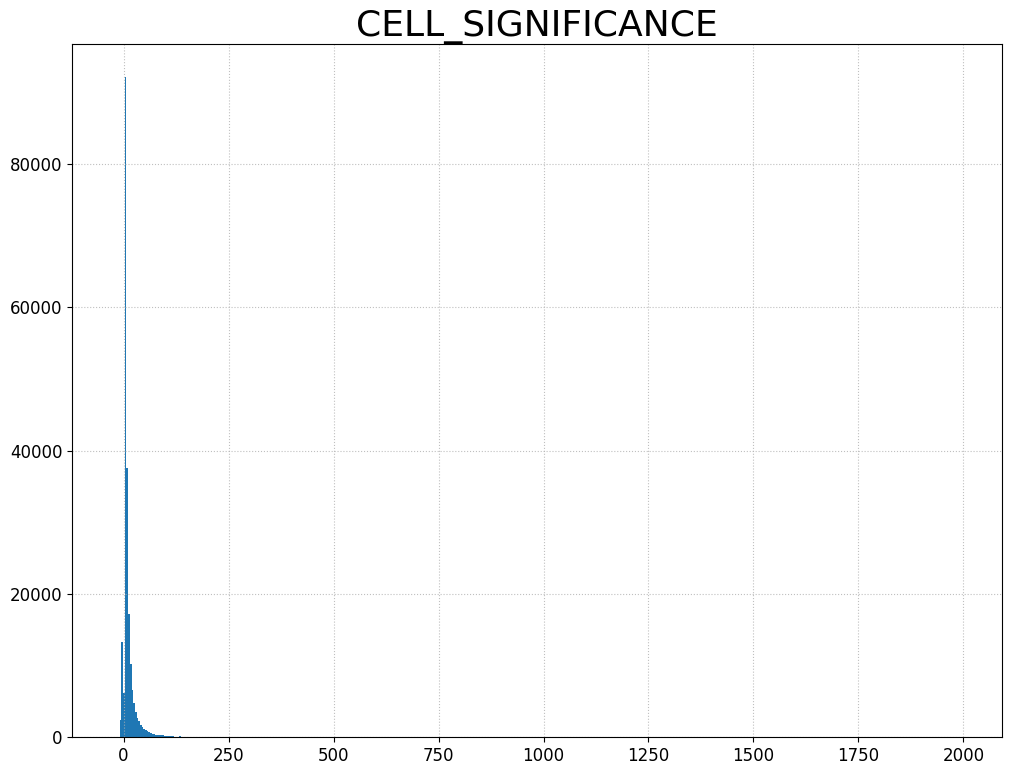

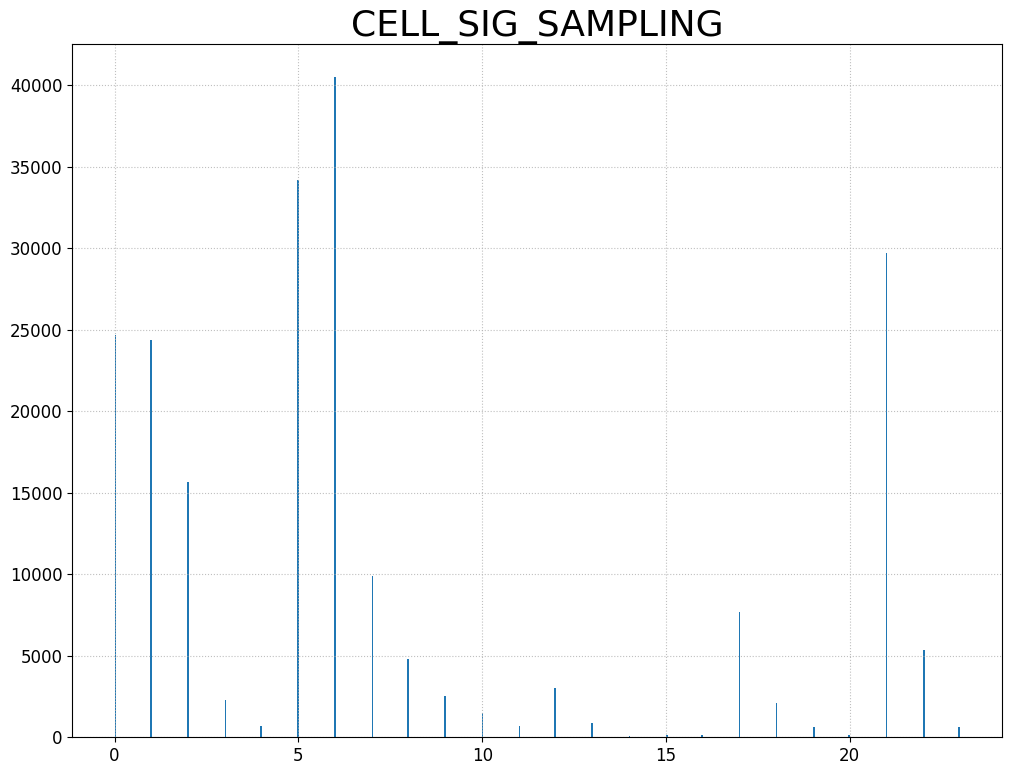

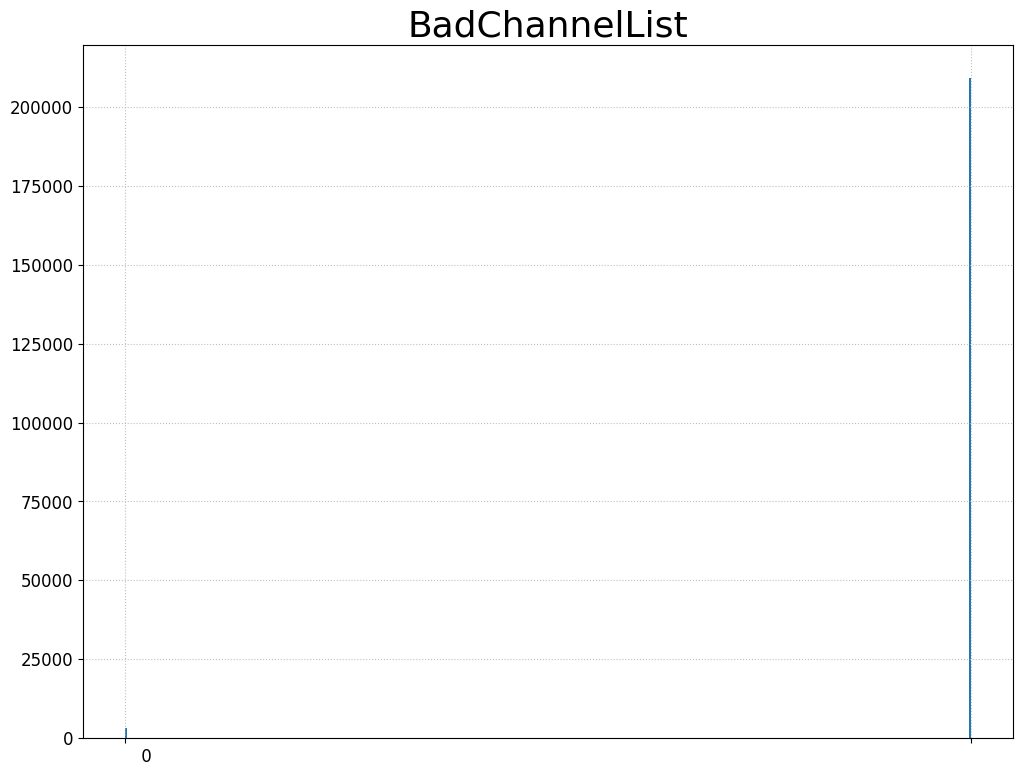

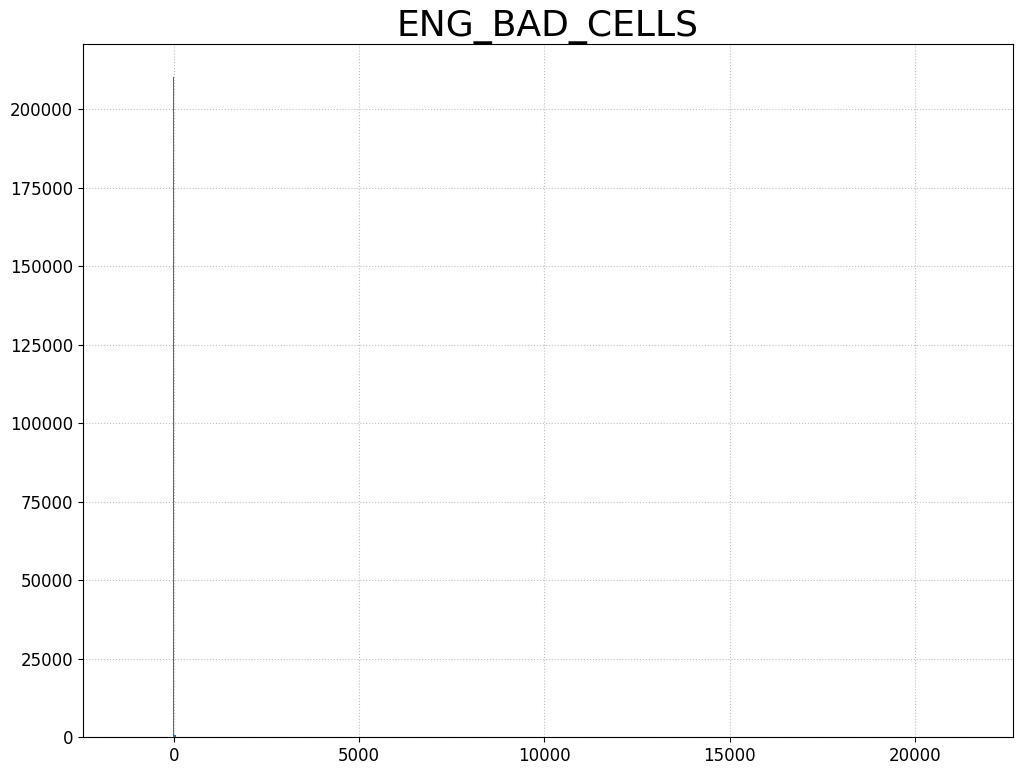

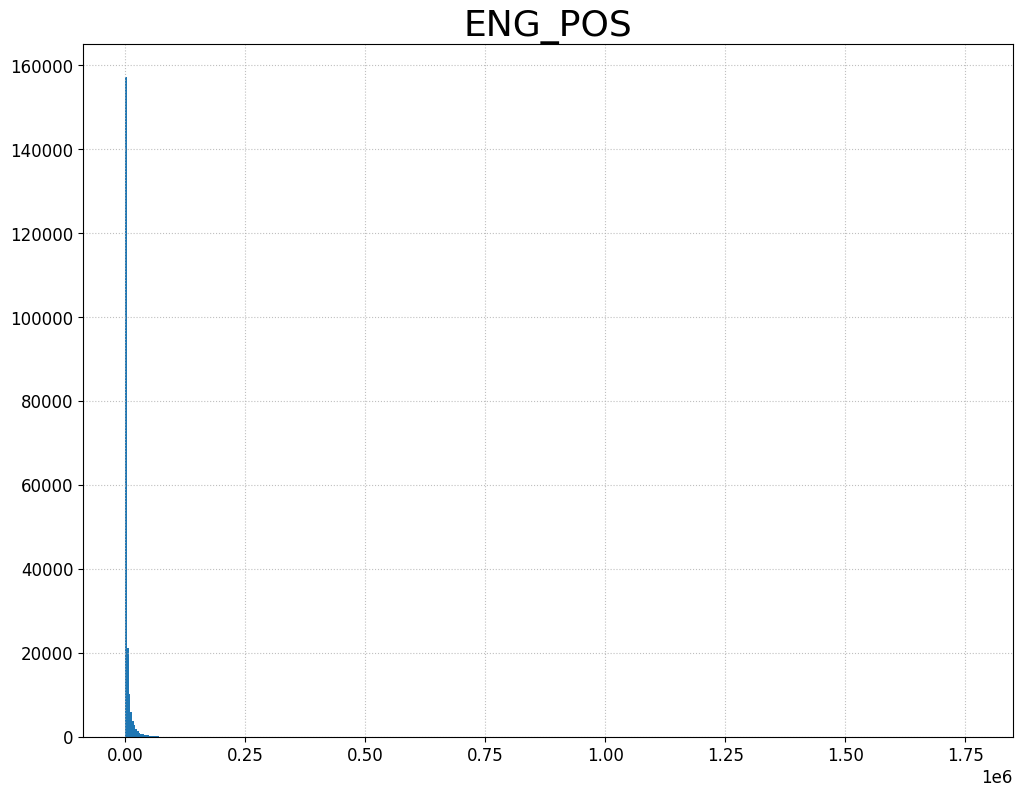

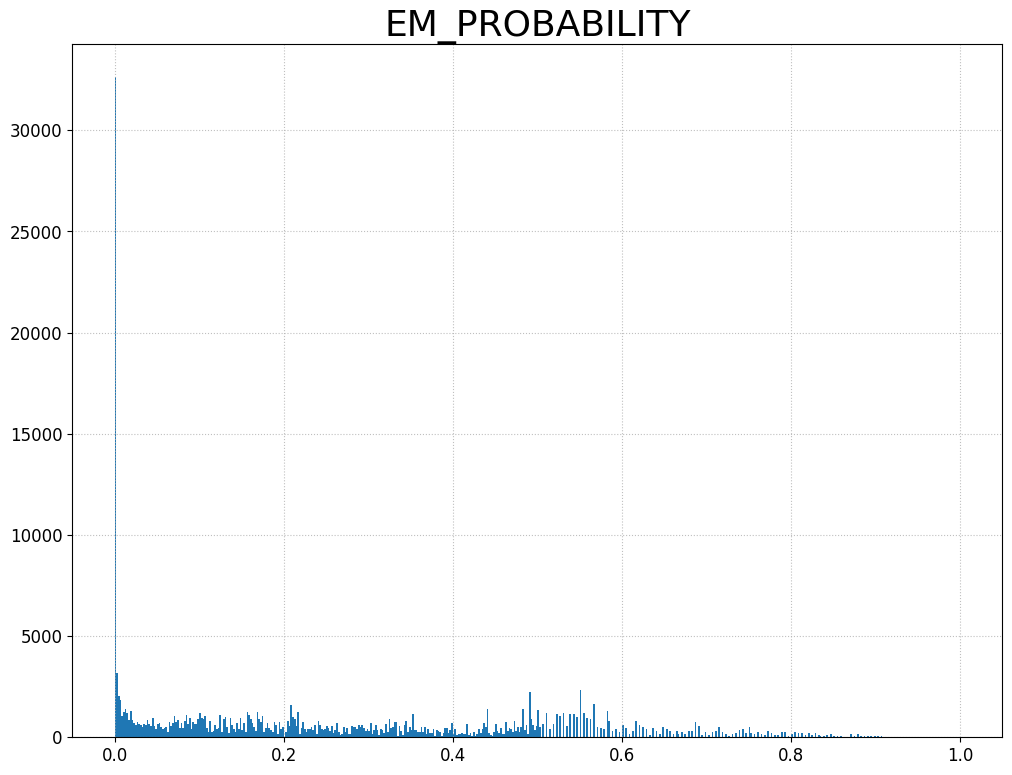

<Figure size 1200x900 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

#Creating Histograms for the data
for col in columns:
    colum = data.loc[:,col]
    plt.hist(colum, bins = 500)
    plt.title(col)
    plt.savefig(f'../plots/{col}_hist')
    plt.show()
    
    plt.clf()

#The plots look alright. However, the weird domains suggest extraneous data.







# Looking for Extraneous Data 

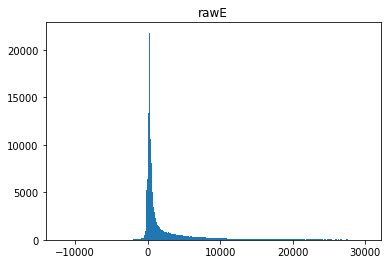

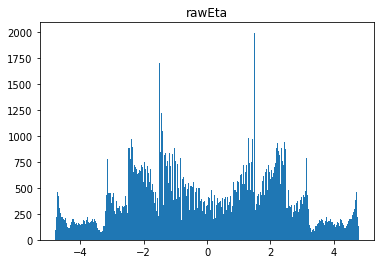

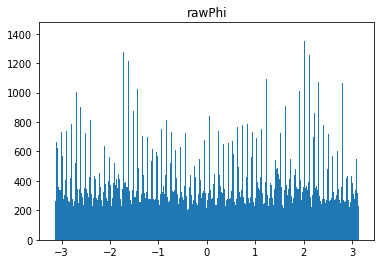

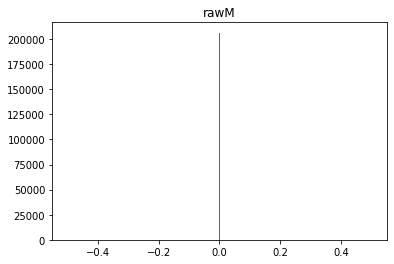

<Figure size 432x288 with 0 Axes>

In [6]:
#log scale energy
data_fixed = data[data['rawE']<30000]
for col in columns:
    colum = data_fixed.loc[:,col]
    plt.hist(colum, bins = 500)
    plt.title(col)
    plt.savefig(f'../plots/{col}_hist')
    plt.show()
    
    plt.clf()

In [7]:
import model_functions as mf
import Plotting_AE
import Wulff_Functions

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
data = data.replace(r'^\s*$', np.NaN, regex=True)
data[data.columns] = StandardScaler().fit_transform(data)

data = shuffle(data)
train_x, test_x = train_test_split(data, test_size=0.2, random_state=1)
train_y = train_x
test_y = test_x
print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)
print(test_x.columns)
data = torch.tensor(test_x.values, dtype=torch.float)

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(169867, 4)
Test data shape: 
(42467, 4)
Index(['rawE', 'rawEta', 'rawPhi', 'rawM'], dtype='object')


In [8]:
bs = 512 #Initially set at 256, Trying 500, 1000, 100
##512 is the first to not give spikes
# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
dls = core.DataLoaders(train_dl, valid_dl)

In [9]:
def train_AE(dls,latent_space, neurons_list, act_list, weight_decay):    
    for x,y,z in [(x,y,z) for x in latent_space for y in neurons_list for z in act_list]:
        #Have a function for this
        model = AE(4,x,y,z)
        #This would already be defined
        recorder = learner.Recorder()
        learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=nn.MSELoss())
        start = time.perf_counter() # Starts timer
        # train our autoencoder for 100 epochs
        learn.fit_one_cycle(1, 0.00108)
        end = time.perf_counter() # Ends timer
        delta_t = end - start
        print(delta_t)
        z = str(z)
        n1,n2,n3 = tuple(y)
        save_dir = f'../plots/{n1}-{n2}-{n3}-{x}__{z[0:9]}'
        try:
            os.mkdir(save_dir)
        except FileExistsError:
            shutil.rmtree(save_dir)
        finally:
            os.mkdir(save_dir)


        #Plotting Loss and recording validation and time
        recorder.plot_loss()
        plt.savefig(os.path.join(save_dir,'_loss'), format='png')
        plt.clf()
        val = learn.validate()
        val =str(val)
        valid_time_file = save_dir + '/valid_time'
        f = open(valid_time_file,'w')
        f.write("Validation Error: ")
        f.write(val)
        f.write('\n')
        f.write(str(delta_t))
        f.close()

3 [200, 100, 10] Tanh()


epoch,train_loss,valid_loss,time
0,0.070065,0.075890,00:04
0,0.070065,0.075890,00:04


4.2550449749978725


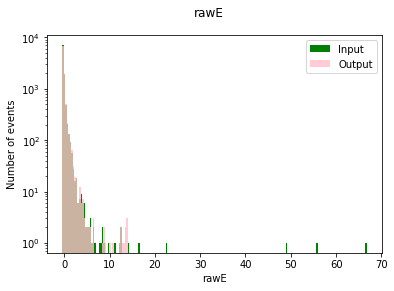

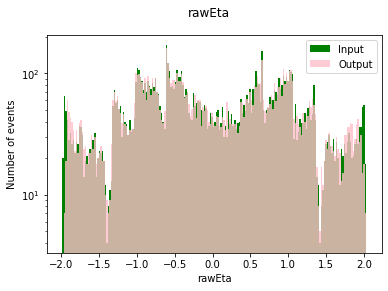

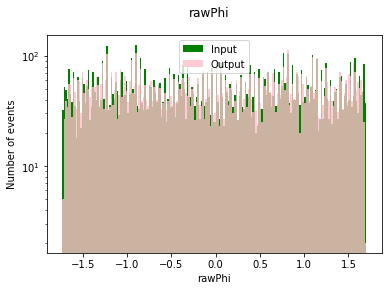

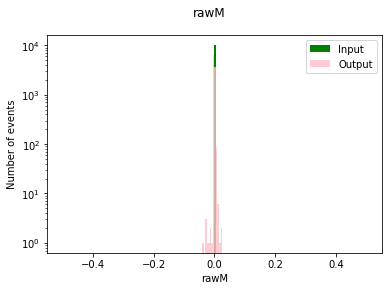

In [10]:
from Plotting_AE import *
from model_functions import *
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *
import time
from fastai.callback import schedule
import os
import shutil
import Wulff_Functions as wu

#Multiply to get total number of combinations

loss_function = nn.MSELoss()
weight_decay = 1e-6
latent_space = [3]
neurons_list = [[200,100,10]]
act_list = [nn.Tanh()]

#This takes all the arguments given above and loops over all possible arrangements
#For some reason this part of the code does not work within a function
for x,y,z in [(x,y,z) for x in latent_space for y in neurons_list for z in act_list]:
    print(x,y,z)
    model = AE(4,x,y,z)
    #This would already be defined
    recorder = learner.Recorder()
    learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)
    start = time.perf_counter() # Starts timer
    # train our autoencoder for 100 epochs
    learn.fit_one_cycle(1, 0.00108)
    end = time.perf_counter() # Ends timer
    delta_t = end - start
    print(delta_t)
    z = str(z)
    n1,n2,n3 = tuple(y)
    save_dir = f'../plots/{n1}-{n2}-{n3}-{x}__{z[0:9]}'
    
    #Creates a folder containing the plot_loss, validation, time if it doesn't already exist.
    #If the folder already exists, the program deletes the folder and recreates it.d
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        shutil.rmtree(save_dir)
    finally:
        os.mkdir(save_dir)
    
    
    #Plotting Loss and recording validation and time
    recorder.plot_loss()
    plt.savefig(os.path.join(save_dir,'_loss'), format='png')
    plt.clf()
    val = learn.validate()
    val =str(val)
    valid_time_file = save_dir + '/valid_time'
    f = open(valid_time_file,'w')
    f.write("Validation Error: ")
    f.write(val)
    f.write('\n')
    f.write(str(delta_t))
    f.close()
    
    #Plotting Final Results
    plt.clf
    plt.close('all')
    unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
    variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
    line_style = ['--', '-']
    colors = ['pink', 'green']
    markers = ['*', 's']

    model.to('cpu')
    save = True
    idxs = (0, 10000)  # Choose events to compare
    data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

    pred = model(data)
    pred = pred.detach().numpy()
    data = data.detach().numpy()

    data_df = pd.DataFrame(data, columns=test_x.columns)
    pred_df = pd.DataFrame(pred, columns=test_x.columns)

    alph = 0.8
    n_bins = 200
    
    #Plotting output data
    for kk in np.arange(4):
        plt.figure()
        n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
        n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
        plt.suptitle(test_x.columns[kk])
        plt.xlabel(test_x.columns[kk])
        plt.ylabel('Number of events')
        # ms.sciy()
        plt.yscale('log')
        if save:
            plt.savefig(os.path.join(save_dir,test_x.columns[kk] + '.png'))
        plt.legend()
    
    

In [11]:
pred_df.isnull().values.any()

False

In [12]:
data_df.isnull().values.any()

False

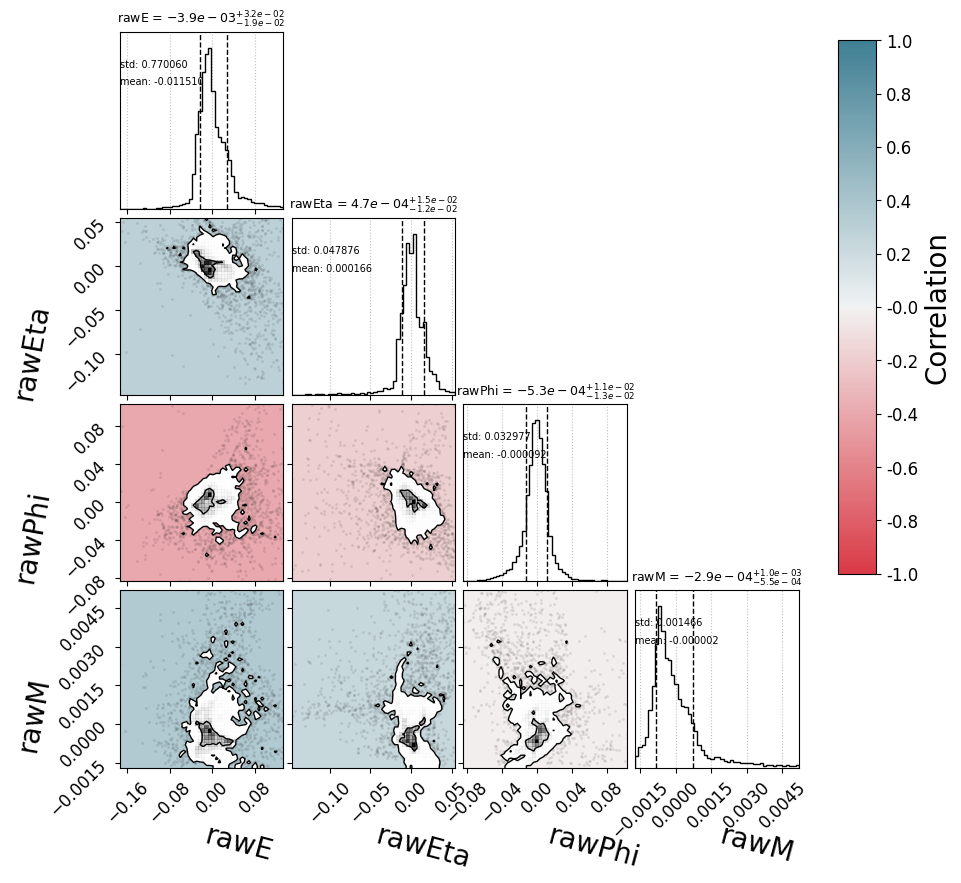

In [13]:
rel_diff_list = ['rawE', 'rawEta', 'rawPhi','rawM']
corner_groups = [rel_diff_list]
wu.corr_matrix(4,3,'.',pred_df,data_df,rel_diff_list,corner_groups)